In [1]:
%load_ext autoreload
import ddls

In [2]:
# # TEST

# %autoreload
# from ddls.utils import ddls_graph_from_pipedream_txt_file

# ddls_graph = ddls_graph_from_pipedream_txt_file(file_path='/scratch/datasets/ddls/jobs/pipedream_graphs/image_classification/profiles/alexnet/graph.txt',
#                                                 processor_type_profiled='A100',
#                                                 verbose=True)

In [58]:
%autoreload
from ddls.devices.processors.gpus.A100 import A100
from ddls.distributions.uniform import Uniform

node_config = {'type_1':
                  {
                      'num_nodes': 16, # 8 16
                      'workers_config': 
                          [
                              {
                               'num_workers': 1, # NEED 1 WORKER PER SERVER FOR RAMP
                               'worker': A100
                              }
                          ]
                  }
              }

# topology_config = {'type':
#                       'torus',
#                    'kwargs':
#                       {
#                           'x_dims': 10, # 4 8
#                           'y_dims': 10, # 4 8
#                           'num_channels': 122, # 64
#                       }
#                   }

topology_config = {'type':
                      'ramp',
                   'kwargs':
                      {
                          'num_communication_groups': 2,
                          'num_racks_per_communication_group': 2,
                          'num_servers_per_rack': 4, # 2 4
                          'num_channels': 2
                      }
                  }

# jobs_config = {'path_to_files': '/scratch/datasets/ddls/jobs/tensorflow_synthetic_graphs/valid',
#                'job_interarrival_time_dist': Uniform(min_val=1, max_val=1000),
#                'max_files': 20,
#                'job_sampling_mode': 'remove'}

jobs_config = {'path_to_files': '/scratch/datasets/ddls/jobs/pipedream_graphs/image_classification/profiles/alexnet/',
               'job_interarrival_time_dist': Uniform(min_val=1, max_val=1000),
               'max_files': 20,
               'job_sampling_mode': 'remove'}

Cluster <class 'ddls.environments.ramp_cluster.ramp_cluster_environment.RampClusterEnvironment'> | Topology: <class 'ddls.topologies.ramp.Ramp'> with 16 nodes and 120 edges | Topology config: {'type': 'ramp', 'kwargs': {'num_communication_groups': 2, 'num_racks_per_communication_group': 2, 'num_servers_per_rack': 4, 'num_channels': 2}} | Node config: {'type_1': {'num_nodes': 16, 'workers_config': [{'num_workers': 1, 'worker': <class 'ddls.devices.processors.gpus.A100.A100'>}]}}


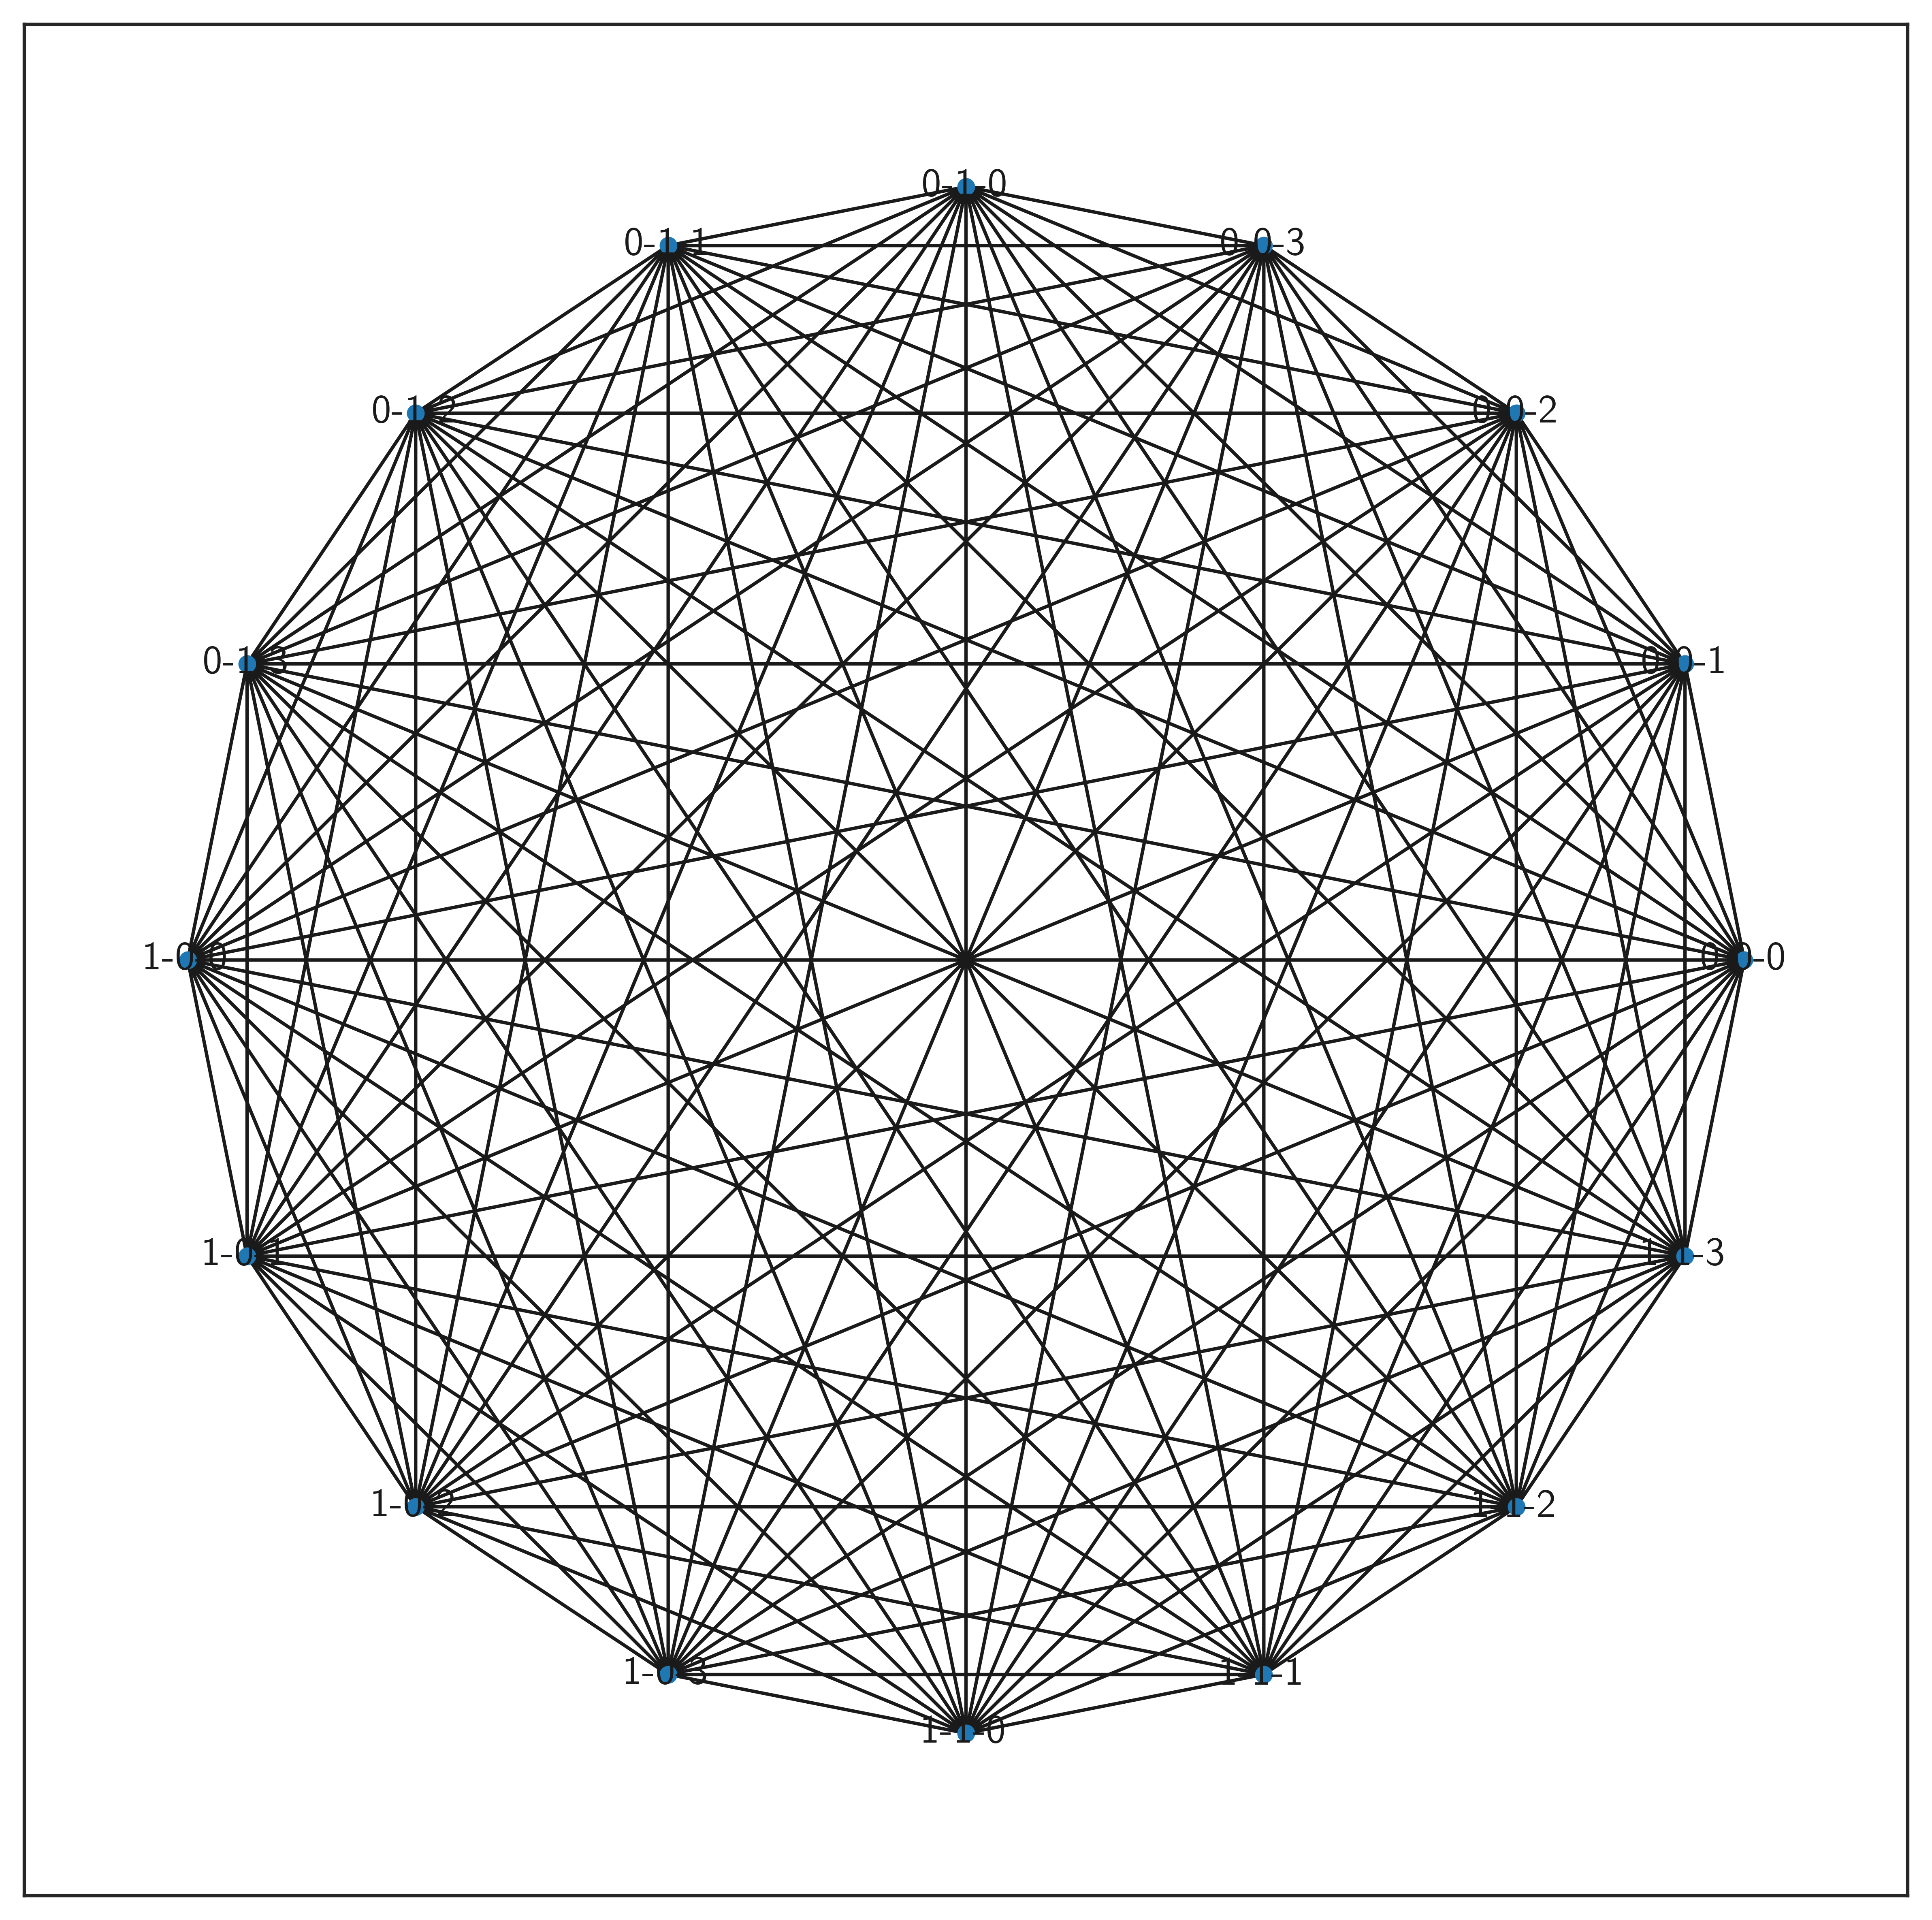

Node 0-0-0: {'workers': {'node_0-0-0_worker_0': <ddls.devices.processors.gpus.A100.A100 object at 0x7f3d82168fd0>}} | Num edges: 15
Node 0-0-1: {'workers': {'node_0-0-1_worker_0': <ddls.devices.processors.gpus.A100.A100 object at 0x7f3d82158fa0>}} | Num edges: 15
Node 0-0-2: {'workers': {'node_0-0-2_worker_0': <ddls.devices.processors.gpus.A100.A100 object at 0x7f3d82158f70>}} | Num edges: 15
Node 0-0-3: {'workers': {'node_0-0-3_worker_0': <ddls.devices.processors.gpus.A100.A100 object at 0x7f3d82158f40>}} | Num edges: 15
Node 0-1-0: {'workers': {'node_0-1-0_worker_0': <ddls.devices.processors.gpus.A100.A100 object at 0x7f3d82158f10>}} | Num edges: 15
Node 0-1-1: {'workers': {'node_0-1-1_worker_0': <ddls.devices.processors.gpus.A100.A100 object at 0x7f3d82158ee0>}} | Num edges: 15
Node 0-1-2: {'workers': {'node_0-1-2_worker_0': <ddls.devices.processors.gpus.A100.A100 object at 0x7f3d82158eb0>}} | Num edges: 15
Node 0-1-3: {'workers': {'node_0-1-3_worker_0': <ddls.devices.processors.gpu

In [60]:
%autoreload
from ddls.environments.ramp_cluster.ramp_cluster_environment import RampClusterEnvironment

env = RampClusterEnvironment(topology_config=topology_config,
                             node_config=node_config,
                             path_to_save='/scratch/datasets/ddls/sims',
                             save_freq=100,
                             use_sqlite_database=True)
print(env)
env.topology.render(label_node_names=True)

for node in env.topology.graph:
    print(f'Node {node}: {env.topology.graph.nodes[node]} | Num edges: {len(list(env.topology.graph.edges(node)))}')

In [70]:
%autoreload
from ddls.environments.ramp_cluster.agents.partitioners.random_op_partitioner import RandomOpPartitioner
from ddls.environments.ramp_cluster.agents.partitioners.sip_ml_op_partitioner import SipMlOpPartitioner
from ddls.environments.ramp_cluster.agents.job_placement_shapers.ramp_random_job_placement_shaper import RampRandomJobPlacementShaper
from ddls.environments.ramp_cluster.agents.placers.random_op_placer import RandomOpPlacer
from ddls.environments.ramp_cluster.agents.placers.ramp_random_op_placer import RampRandomOpPlacer
from ddls.environments.ramp_cluster.agents.schedulers.srpt_op_scheduler import SRPTOpScheduler
from ddls.environments.ramp_cluster.agents.placers.first_fit_dep_placer import FirstFitDepPlacer
from ddls.environments.ramp_cluster.agents.schedulers.srpt_dep_scheduler import SRPTDepScheduler

control_plane = {
    # 'op_partitioner': RandomOpPartitioner(max_partitions_per_op=2),
    'op_partitioner': SipMlOpPartitioner(min_op_run_time_quantum=10e-6, max_partitions_per_op=6),
    # 'op_partitioner': SipMlOpPartitioner(min_op_run_time_quantum=10e-6, max_partitions_per_op=5),
    'job_placement_shaper': RampRandomJobPlacementShaper(),
    'op_placer': RampRandomOpPlacer(),
    'op_scheduler': SRPTOpScheduler(),
    'dep_placer': FirstFitDepPlacer(),
    'dep_scheduler': SRPTDepScheduler()
}

In [73]:
%autoreload
from ddls.distributions.uniform import Uniform
from ddls.utils import seed_stochastic_modules_globally
from ddls.environments.ramp_cluster.actions.action import Action

import time
import pprint


# seeds = [0, 1, 2]
seeds = [0]
verbose = True

for seed in seeds:
    print(f'\n\n\n~~~~~~~~~~~~~~~~~~~~~~~ Seed {seed} ~~~~~~~~~~~~~~~~~~~~~~~')
    seed_stochastic_modules_globally(seed)
    obs = env.reset(jobs_config=jobs_config,
                    max_simulation_run_time=float('inf'),
                    job_queue_capacity=100,
                    seed=seed,
                    verbose=True)
    
    done, t = False, 0
    start_time = time.time()
    while not done:
        # make decisions
        # list(env.job_queue.jobs.values())[0].render()
        op_partition = control_plane['op_partitioner'].get(cluster=env)
        job_placement_shape = control_plane['job_placement_shaper'].get(op_partition=op_partition, cluster=env)
        op_placement = control_plane['op_placer'].get(op_partition=op_partition, job_placement_shape=job_placement_shape, cluster=env)
        op_schedule = control_plane['op_scheduler'].get(op_partition=op_partition, op_placement=op_placement, cluster=env)      
        dep_placement = control_plane['dep_placer'].get(op_partition=op_partition, op_placement=op_placement, cluster=env)      
        dep_schedule = control_plane['dep_scheduler'].get(op_partition=op_partition, dep_placement=dep_placement, cluster=env)
        # list(op_partition.partitioned_jobs.values())[0].render()
        # raise Exception()
        
        # syncronise decisions into class of valid decisions action
        action = Action(op_partition=op_partition,
                        job_placement_shape=job_placement_shape,
                        op_placement=op_placement,
                        op_schedule=op_schedule,
                        dep_placement=dep_placement,
                        dep_schedule=dep_schedule)
        if verbose:
            print(f'\n\nt={t} action: {action}')
                        
        # pass decisions action to cluster environment and step the cluster
        obs, action_set, reward, done, info = env.step(action,
                                                       verbose=verbose)
        if not verbose:
            print(f'Step {env.step_counter} | Jobs arrived: {env.num_jobs_arrived} | completed: {len(env.jobs_completed)} | blocked: {len(env.jobs_blocked)} | running: {len(env.jobs_running)} | queued: {len(env.job_queue)}')
        
        t += 1
    
    print(f'\nCompleted simulation in {time.time() - start_time:.3f} s')




~~~~~~~~~~~~~~~~~~~~~~~ Seed 0 ~~~~~~~~~~~~~~~~~~~~~~~
Initialised folder /scratch/datasets/ddls/sims/ramp_cluster/ramp_cluster_66/reset_7
Reset cluster environment.
Max sim run time: inf
action job ids: {139902345007888}


t=0 action: 
op_partition:
Job ID: 139902345007888
	Op ID 11 -> Partition into 6 sub-ops
	Op ID 36 -> Partition into 6 sub-ops
	Op ID 10 -> Partition into 6 sub-ops
	Op ID 37 -> Partition into 6 sub-ops
	Op ID 13 -> Partition into 6 sub-ops
	Op ID 34 -> Partition into 6 sub-ops
	Op ID 12 -> Partition into 6 sub-ops
	Op ID 35 -> Partition into 6 sub-ops
	Op ID 15 -> No partitioning applied
	Op ID 32 -> No partitioning applied
	Op ID 14 -> Partition into 6 sub-ops
	Op ID 33 -> Partition into 6 sub-ops
	Op ID 17 -> No partitioning applied
	Op ID 30 -> No partitioning applied
	Op ID 16 -> No partitioning applied
	Op ID 31 -> No partitioning applied
	Op ID 19 -> Partition into 6 sub-ops
	Op ID 28 -> Partition into 6 sub-ops
	Op ID 18 -> Partition into 6 sub-ops
	Op ID

In [ ]:
original_job = list(env.job_queue.jobs.values())[0]
print(original_job)
_ = original_job.render()

partitioned_job = list(op_partition.partitioned_jobs.values())[0]
print(partitioned_job)
_ = partitioned_job.render()

# Problem: What is the meaning of bidirectional (all-to-all) dependencies?

- Consider we have a graph of 3 nodes and 4 edges:
    - 1A -> 1B
    - 1B -> 1A
    - 1A -> 2
    - 1B -> 2
- A directed edge is a dependency. Previously, considered the parent of the edge to be the parent of a given child, where the parent must be completed before the child dependency (and then the child node operation) can begin
- However, in above example, the 1A -> 1B and 1B -> 1A dependencies will never be 'ready', since 1A cannot be ready until its parent 1B is completed, as vice versa for 1B. 
- Lets refer to the 1A -> 1B and 1B -> 1A edges as a **bidirectional dependency** 1A <-> 1B
- **Question**: When is one of these bidirectional dependencies actually executed in a deep learning job?
    - Is it when 1A and 1B have both completed (i.e. 1A <-> 1B is just a child dependency of 1A and 1B)?
        - If so, why do 1A and 1B have a dependency between them, since they can both be executed independently of one another and these edges are just child dependencies linked to the 1A and 1B child ops?
    - Is it before 1A and 1B are ready?
        - If so, why do 1A and 1B have a dependency between them, since they can both be executed independently of one another and these edges are just parent dependencies linked to the 1A and 1B parent ops?
    - Is it while 1A and 1B are being executed?
        - If so, when does the actual communication occur between 1A and 1B whilst they're being executed? 
        
**Search for CHANGE in `job.py` to see switches between above (only uncommented works without infinite loops)**


# Conclusion:

Any bidirectional edges (i.e. 'synchronisation edges') represent the process of synchronising backprop model weight updates between two ops. Therefore, once the parent op of each respective directed edge in the bidirectional edge has been completed, that edge can begin execution. In other words, bidirectional edges are child dependencies of their parent ops, but they are not the parent of any other op, so they can begin being executed while other dependencies and ops beneath their parent ops are being executed.

In [ ]:
a = 'node_1-0-1'
print(a.split('node_'))

a = '1-0-1'
print(a.split('-'))

In [ ]:
run_time = 10
min_op_run_time_quantum = 3

print(run_time // min_op_run_time_quantum)